In [ ]:
import sys
from os import path
sys.path.append(path.join(path.dirname(path.abspath("__file__")), '..'))
# sys.path.append(path.join(path.dirname(path.abspath("__file__")), '..'))
import aestimo as solver
import config as ac
ac.messagesoff = True # turn off logging in order to keep notebook from being flooded with messages.
import database as adatabase
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import copy
from pprint import pprint
     

In [ ]:

class Structure(object): pass
s0 = Structure() # this will be our datastructure

# TEMPERATURE
s0.T = 11.0 #Kelvin

# COMPUTATIONAL SCHEME
# 0: Schrodinger
# 1: Schrodinger + nonparabolicity
# 2: Schrodinger-Poisson
# 3: Schrodinger-Poisson with nonparabolicity
# 4: Schrodinger-Exchange interaction
# 5: Schrodinger-Poisson + Exchange interaction
# 6: Schrodinger-Poisson + Exchange interaction with nonparabolicity
s0.computation_scheme = 0

# Non-parabolic effective mass function
# 0: no energy dependence
# 1: Nelson's effective 2-band model
# 2: k.p model from Vurgaftman's 2001 paper
s0.meff_method = 0

# Non-parabolic Dispersion Calculations for Fermi-Dirac
s0.fermi_np_scheme = True #needed only for aestimo_numpy2.py

# QUANTUM
# Total subband number to be calculated for electrons
s0.subnumber_e = 2

# APPLIED ELECTRIC FIELD
s0.Fapplied = 0.00 # (V/m)

# GRID
# For 1D, z-axis is choosen
s0.gridfactor = 0.1 #nm
s0.maxgridpoints = 200000 #for controlling the size

# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
well_l = 5.0
s0.material =[
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ well_l, 'GaAs', 0, 2e16, 'n'],
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            ]

structure0 = s0

In [ ]:
q = 1.602176e-19 #C
meV2J=1e-3*q #meV to Joules

In [34]:
def plot_QW_view(result, title, wavefunction_scalefactor=None):
    """
    Plots the quantum well view with wavefunctions.

    Parameters:
    - result: The simulation result containing wavefunctions and energy levels.
    - title: Title of the plot.
    - wavefunction_scalefactor: Optional. Scaling factor for the wavefunctions. Defaults to ac.wavefunction_scalefactor.
    """
    fig2 = plt.figure()
    plt.suptitle(title)
    plt.subplot(1, 1, 1)
    plt.plot(result.xaxis * 1e9, result.fitot / meV2J, "k", label="Potential")
    
    # Use the provided scaling factor or default to ac.wavefunction_scalefactor
    scaling_factor = wavefunction_scalefactor if wavefunction_scalefactor is not None else ac.wavefunction_scalefactor
    
    # Generate a colormap for the wavefunctions
    # colormap = plt.get_cmap('Blues', len(result.wfe))
    colormap = plt.get_cmap('cividis')
    
    for i, (level, state) in enumerate(zip(result.E_state, result.wfe)):
        wfsq = state**2
        color = colormap(i / len(result.wfe))  # Get a shade of blue
        plt.axhline(level, 0.1, 0.9, color="g", ls="--")
        plt.plot(result.xaxis * 1e9, wfsq * scaling_factor + level, color=color)
    
    plt.axhline(result.E_F, 0.1, 0.9, color="r", ls="--", label="chemical potential")
    plt.xlabel("Position (nm)")
    plt.ylabel("Energy (meV)")
    plt.grid(True)
    plt.legend()
    return fig2

INFO Total layer number: 3
INFO Total number of materials in database: 25
INFO calculation time  3.54879 s


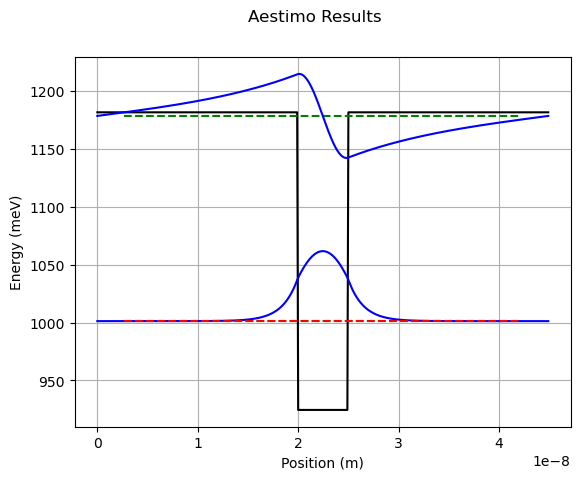

INFO Simulation is finished.


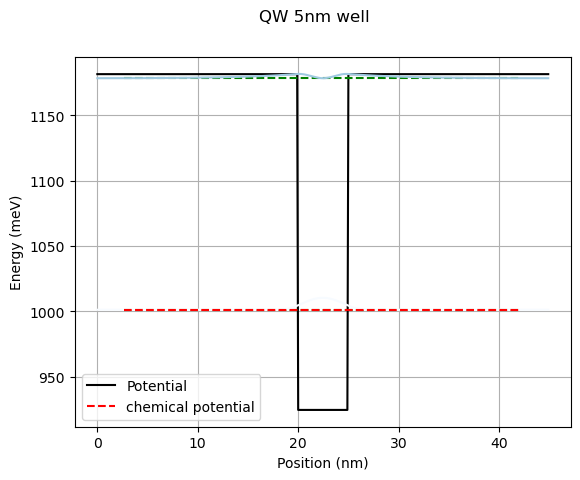

In [24]:
# Initialise structure class
model = solver.StructureFrom(structure0,adatabase) # structure could also be a dictionary.
    
#calculate QW states
result = solver.Poisson_Schrodinger(model)

%matplotlib inline
#solver.save_and_plot(result,model) # Write the simulation results in files
solver.QWplot(result,figno=None) # Plot QW diagram
solver.logger.info("Simulation is finished.")

figtest = plot_QW_view(result, "QW 5nm well")

INFO Total layer number: 5
INFO Total number of materials in database: 25
INFO calculation time  4.42078 s


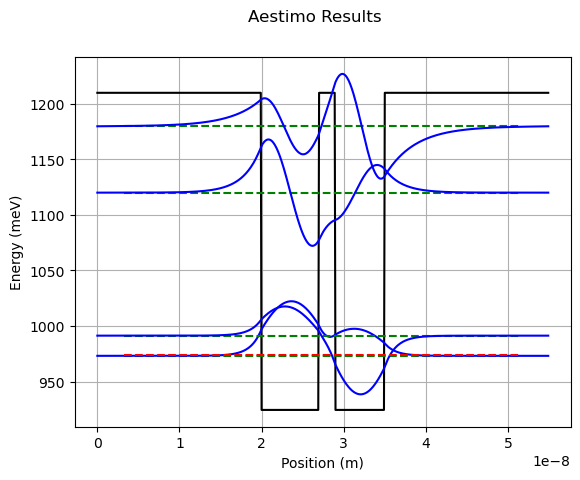

INFO Simulation is finished.


In [36]:
s1 = copy.copy(s0) #simpler than redefining everything and changes to s0 should propagate to s1
x_conc = 0.33
s1.material = [
            [ 20.0, 'AlGaAs', x_conc, 0.0, 'n'],
            [ 7.0, 'GaAs', 0, 2e16, 'n'],
            [2.0, 'AlGaAs', x_conc, 0.0, 'n'], #barrier layer
            [ 6.0, 'GaAs', 0, 2e16, 'n'],            
            [ 20.0, 'AlGaAs', x_conc, 0.0, 'n'],
            ]
barrier_layer = 2 # defines which layer will be adjusted later
s1.subnumber_e = 4 # There will be double the number of energy states now.

# Initialise structure class
model1 = solver.StructureFrom(s1,adatabase) # structure could also be a dictionary.

#calculate QW states
result1 = solver.Poisson_Schrodinger(model1)

#solver.save_and_plot(result,model)
solver.QWplot(result1,figno=None)
solver.logger.info("Simulation is finished.")
     

state, Energy
     ,meV
    0 973.152
    1 991.298
    2 1119.93
    3 1179.62


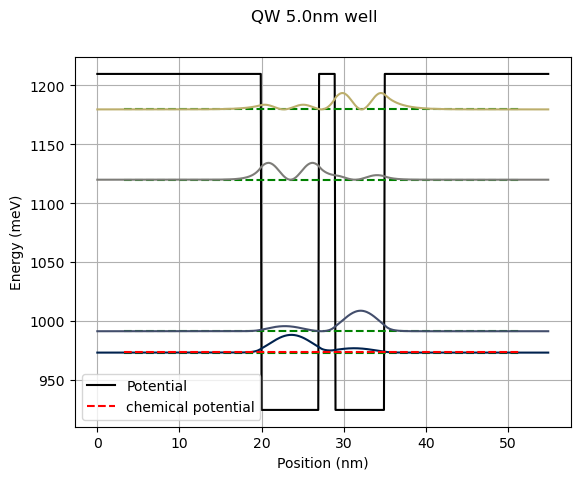

In [37]:
figtest2 = plot_QW_view(result1, "QW " + str(well_l) + "nm well",wavefunction_scalefactor=1000)

print('state, Energy')
print('     ,meV')
for num,E in zip(range(result1.subnumber_e),result1.E_state):
    print('%5d %7g' %(num,E))

In [ ]:
q = 1.602176e-19 #C
meV2J=1e-3*q #meV to Joules
# Shooting method parameters for Schrödinger Equation solution
ac.delta_E = 0.005*meV2J #Energy step (Joules) for initial search. Initial delta_E is 1 meV. 
#ac.d_E = 1e-5*meV2J #Energy step (Joules) within Newton-Raphson method when improving the precision of the energy of a found level.
#ac.E_start = 0.0    #Energy to start shooting method from (if E_start = 0.0 uses minimum of energy of bandstructure)
#ac.Estate_convergence_test = 1e-9*meV2J
def set_barrier(d):
    """Sets barriers between the two QWs to d (nm)."""
    model1.material[barrier_layer][0] = d
    model1.create_structure_arrays() # update the instance's internals

results = []
barriers = np.arange(1,20,step=2)
for barrier in barriers:
    set_barrier(barrier)
    resulti = solver.Poisson_Schrodinger(model1)
    results.append(resulti.E_state)

results = np.array(results)

ax1 = plt.subplot(111)
for level in results.transpose(): ax1.plot(barriers,level)
ax1.invert_xaxis()
ax1.set_xlabel("barrier thickness (nm)")
ax1.set_ylabel("Energy (meV)")
plt.show()